## 📊 Projeto – Stacking Classificação

Uma **EdTech** possui uma plataforma de vendas para oferta de seus produtos de educação e, com o objetivo de priorizar melhor suas ações comerciais, quer desenvolver uma estratégia para **ampliar seu fator de conversão de leads** em vendas. Atualmente, as informações referentes a este processo de vendas encontram-se em uma **ferramenta de CRM**, da qual podem ser extraídos alguns insights.

Desta forma, para apoiar no desenvolvimento desta estratégia, iremos trabalhar num **algoritmo de classificação** que possa **prever se um lead será ou não convertido em venda**. E, dado o volume de dados e as features disponíveis, adotaremos o **método Stacking de ensemble, usando algoritmos supervisionados de classificação**.

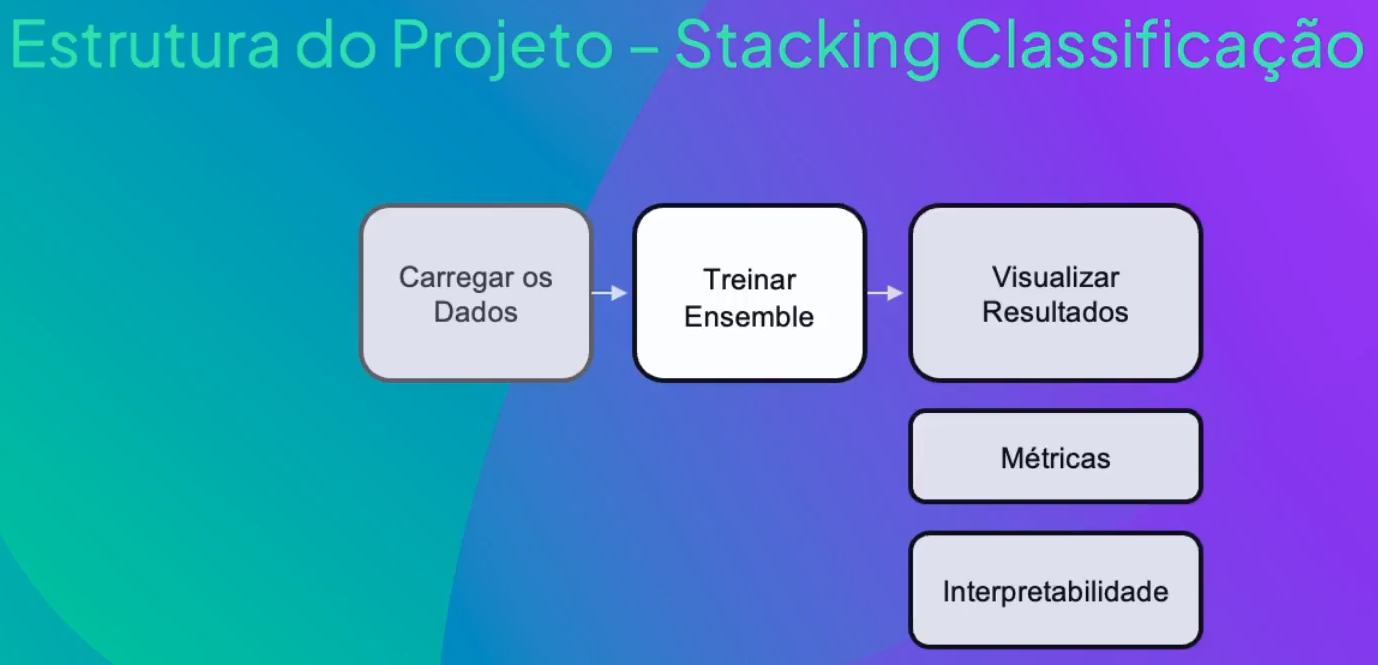

In [2]:
# Importar as bibliotecas

# EDA
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Carregar os dados

In [3]:
# Carregar os dados ja tratados
df_leads = pd.read_csv('./datasets/leads_cleaned.csv')

In [4]:
# Mostrar as linhas iniciais
df_leads.head(10)

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,0,0,0,0,0,0,0,Modified
1,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,0,0,0,0,0,0,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,0,0,0,0,0,0,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Unreachable,0,0,0,0,0,0,0,Modified
4,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Converted to Lead,0,0,0,0,0,0,0,Modified
5,API,Olark Chat,0,0,0,0.0,0,0.0,Olark Chat Conversation,0,0,0,0,0,0,0,Modified
6,Landing Page Submission,Google,0,0,1,2.0,1640,2.0,Email Opened,0,0,0,0,0,0,0,Modified
7,API,Olark Chat,0,0,0,0.0,0,0.0,Olark Chat Conversation,0,0,0,0,0,0,0,Modified
8,Landing Page Submission,Direct Traffic,0,0,0,2.0,71,2.0,Email Opened,0,0,0,0,0,0,1,Email Opened
9,API,Google,0,0,0,4.0,58,4.0,Email Opened,0,0,0,0,0,0,0,Email Opened


In [5]:
# Mostrar as linhas finais
df_leads.tail(10)

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Last Notable Activity
9064,Landing Page Submission,Google,0,0,0,2.0,870,2.00,Email Opened,0,0,0,0,0,0,0,Email Opened
9065,Landing Page Submission,Google,0,0,1,8.0,1016,4.00,Email Opened,0,0,0,0,0,0,0,Email Opened
9066,Landing Page Submission,Direct Traffic,0,0,0,2.0,1770,2.00,SMS Sent,0,0,0,0,0,0,1,SMS Sent
9067,API,Direct Traffic,0,0,1,13.0,1409,2.60,SMS Sent,0,0,0,0,0,0,0,SMS Sent
9068,Landing Page Submission,Direct Traffic,0,0,1,5.0,210,2.50,SMS Sent,0,0,0,0,0,0,0,Modified
9069,Landing Page Submission,Direct Traffic,1,0,1,8.0,1845,2.67,Email Marked Spam,0,0,0,0,0,0,0,Email Marked Spam
9070,Landing Page Submission,Direct Traffic,0,0,0,2.0,238,2.00,SMS Sent,0,0,0,0,0,0,1,SMS Sent
9071,Landing Page Submission,Direct Traffic,1,0,0,2.0,199,2.00,SMS Sent,0,0,0,0,0,0,1,SMS Sent
9072,Landing Page Submission,Google,0,0,1,3.0,499,3.00,SMS Sent,0,0,0,0,0,0,0,SMS Sent
9073,Landing Page Submission,Direct Traffic,0,0,1,6.0,1279,3.00,SMS Sent,0,0,0,0,0,0,1,Modified


In [6]:
# Estrutura do dataset
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9074 entries, 0 to 9073
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9074 non-null   object 
 1   Lead Source                             9074 non-null   object 
 2   Do Not Email                            9074 non-null   int64  
 3   Do Not Call                             9074 non-null   int64  
 4   Converted                               9074 non-null   int64  
 5   TotalVisits                             9074 non-null   float64
 6   Total Time Spent on Website             9074 non-null   int64  
 7   Page Views Per Visit                    9074 non-null   float64
 8   Last Activity                           9074 non-null   object 
 9   Search                                  9074 non-null   int64  
 10  Newspaper Article                       9074 non-null   int6

### Preparação dos dados

In [7]:
# Preparar os dados para o modelo
X = df_leads.drop(columns=['Converted'])
y = df_leads['Converted']

In [8]:
# Criar lista de colunas
numeric_features = X.select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

In [9]:
# Usar preprocessor existente
import joblib
preprocessor = joblib.load('./preprocessor_dataset_leads.pkl')

In [10]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

In [11]:
# Aplicar o preprocessor
X_train = preprocessor.fit_transform(X_train).toarray()
X_test = preprocessor.transform(X_test).toarray()

In [12]:
# Mostrar os conjuntos
print(f'Conjunto de treinamento: {X_train.shape}')
print(f'Conjunto de testes: {X_test.shape}')

Conjunto de treinamento: (7259, 68)
Conjunto de testes: (1815, 68)


### Treinamento do Modelo

In [35]:
# Criar o modelo de StackingClassifier

# Meta-Modelo
lr_model = LogisticRegression(random_state=51)

# Modelos Base
tree_model = DecisionTreeClassifier(random_state=51)
svc_model = SVC(kernel='linear')
sgd_model = SGDClassifier(penalty='elasticnet', random_state=51)

# Criar o objeto do StackingClassifier
stacking_model = StackingClassifier(
    estimators= [
        ('sgd classifier', sgd_model),
        ('svc', svc_model),
        ('decision tree', tree_model)
    ],
    final_estimator=lr_model,
    # Passthrough = False, usa apenas os estimadores de cada algoritmo base
    # Passthrough = True, usa os resultados dos estimadores de cada algoritmo base + dataset original (Blending)
    passthrough=True
)

In [36]:
# Treinar o modelo
stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('sgd classifier',
                                SGDClassifier(penalty='elasticnet',
                                              random_state=51)),
                               ('svc', SVC(kernel='linear')),
                               ('decision tree',
                                DecisionTreeClassifier(random_state=51))],
                   final_estimator=LogisticRegression(random_state=51),
                   passthrough=True)

### Avaliação do Modelo

In [37]:
# Fazer predicoes no conjunto de testes
y_pred = stacking_model.predict(X_test)

In [38]:
# Mostrar y_pred
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [39]:
# Calcular metricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [40]:
# Apresentar as metricas
print(f'Acurácia: {accuracy}')
print(f'Precisão: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Acurácia: 0.7944903581267218
Precisão: 0.746268656716418
Recall: 0.6716417910447762
F1-Score: 0.7069913589945012


In [41]:
# Mostrar a matriz de confusao
conf_matrix = confusion_matrix(y_test, y_pred)

fig = px.imshow(conf_matrix,
                labels=dict(x='Predição', y='Real', color='Contagem'),
                x=['Not Converted', 'Converted'],
                y=['Not Converted', 'Converted'],
                color_continuous_scale='Viridis')

fig.update_traces(text=conf_matrix, texttemplate="%{z}")
fig.update_layout(coloraxis_showscale=False)

fig.show()

In [42]:
# Calcular a importancia das variaveis considerando o Stacking Classifier

importances = []

for estimador in stacking_model.estimators_:
    # Modelos lineares possuem coeficiente
    if hasattr(estimador, 'coef_'):
        importances.append(np.abs(estimador.coef_[0]))
        print(f'Coeficientes do modelo {type(estimador).__name__}')
    elif hasattr(estimador, 'feature_importances_'):
        importances.append(np.abs(estimador.feature_importances_))
        print(f'Feature Importances do modelo {type(estimador).__name__}')
    # Caso nao encontre coef e feature importances
    else:
        print(f'Não foi possível calcular a importância para {type(estimador).__name__}')

Coeficientes do modelo SGDClassifier
Coeficientes do modelo SVC
Feature Importances do modelo DecisionTreeClassifier


In [43]:
# Calcular a media das importancias
importancia_media = np.mean(importances, axis=0)

In [44]:
# Obter os nomes das features
feature_names = (
    numeric_features.tolist() +
    preprocessor.named_transformers_['cat']
        .get_feature_names_out(categorical_features).tolist()
)


In [45]:
# Criar um dataframe com nomes e importancia
df_feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importancia_media})

In [46]:
# Ordenar o dataframe
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=True)

In [47]:
# Mostrar o ranking de importância
fig = px.bar(
    df_feature_importances,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Importância das features dos algoritmos base'
)

fig.update_layout(height=1280, width=1000)

fig.show()

### Propriedades do Modelo

In [50]:
# Mostrar evidencias do Modelo

# Fazer uma predicao num exemplo especifico
X_sample = X_test[7].reshape(1, -1)

# Predicoes individuais dos estimadores
sgd_pred = stacking_model.named_estimators_['sgd classifier'].predict(X_sample)
svc_pred = stacking_model.named_estimators_['svc'].predict(X_sample)
tree_pred = stacking_model.named_estimators_['decision tree'].predict(X_sample)

# Predicao final com o Stacking
stacking_pred = stacking_model.predict(X_sample)

In [51]:
# Exibir os resultados
print(f'Predição do SGD: {sgd_pred[0]}')
print(f'Predição do SVC: {svc_pred[0]}')
print(f'Predição da Árvore de Decisão: {tree_pred[0]}')
print(f'Predição final do Stacking (Logistic Regression): {stacking_pred[0]}')

Predição do SGD: 0
Predição do SVC: 0
Predição da Árvore de Decisão: 1
Predição final do Stacking (Logistic Regression): 0
